In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from catboost import CatBoostRegressor

In [2]:
# Load the data
data_df_encoded = pd.read_csv("./data/processed_data.csv")

In [3]:
# Split the data
X = data_df_encoded.drop(columns=["price", "Log Price"])  # Features
y = data_df_encoded["Log Price"]  # Target (log-transformed price)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
# Step 3: Feature Selection

# Correlation-Based Filtering
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_correlation_features = [
    column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)
]
X_selected = X.drop(columns=high_correlation_features)


X_train_selected = X_train[X_selected.columns]

# Univariate Feature Importance
# Use RandomForest to calculate feature importances
importance_model = RandomForestRegressor(random_state=42)
importance_model.fit(X_train, y_train)

# Rank features by importance
feature_importances = pd.Series(
    importance_model.feature_importances_, index=X_train.columns
)
top_features = feature_importances.nlargest(25).index

# Ensure top features exist in X_train_selected
top_features = [
    feature for feature in top_features if feature in X_train_selected.columns
]
X_train_selected = X_train_selected[top_features]

#Recursive Feature Elimination (RFE)
rfe_model = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=20, step=1)

# Fit RFE on the subset of X_train_selected and y_train
rfe.fit(X_train_selected, y_train)

# Select final features based on RFE
selected_features_rfe = X_train_selected.columns[rfe.support_]
X_train_final = X_train_selected[selected_features_rfe]

# Apply the same transformation to X_test
X_test_final = X_test[X_train_final.columns]

print("Selected Features After RFE:", list(selected_features_rfe))

Selected Features After RFE: ['Cubic Capacity', 'Power', 'First Registration Year', 'Category_Van / Minibus', 'Make_Audi', 'Mileage', 'Emission Class_Euro5', 'Mileage per Year', 'Make_Seat', 'Category_SUV / Off-road Vehicle / Pickup Truck', 'Transmission_Automatic', 'Climatisation_Automatic climatisation, 3 zones', 'Make_Volkswagen', 'Make_Skoda', 'Climatisation_Automatic climatisation, 2 zones', 'Category_Saloon', 'Parking sensors_Rear', 'Fuel_Petrol', 'Parking sensors_Front, Rear', 'Vehicle condition_Used vehicle']


In [5]:
# Train Models (Without Hyperparameter Tuning) with Selected Features to get a sense of performance
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        random_state=42, max_depth=10, n_estimators=100
    ),
    "SVR": SVR(kernel="rbf"),
    "CatBoost": CatBoostRegressor(
        verbose=0, random_state=42, learning_rate=0.05, iterations=500, depth=4
    ),
}

baseline_results = {}
for name, model in models.items():
    model.fit(X_train_final, y_train)

    predictions_test = model.predict(X_test_final)
    predictions_train = model.predict(X_train_final)

    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
    r2_test = r2_score(y_test, predictions_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    r2_train = r2_score(y_train, predictions_train)

    baseline_results[name] = {
        "RMSE Test": rmse_test,
        "R² Test": r2_test,
        "RMSE Train": rmse_train,
        "R² Train": r2_train,
    }

print("Baseline Model Results:")
for name, metrics in baseline_results.items():
    print(
        f"{name}: RMSE Train = {metrics['RMSE Train']:.4f}, R² Train = {metrics['R² Train']:.4f}, "
        f"RMSE Test = {metrics['RMSE Test']:.4f}, R² Test = {metrics['R² Test']:.4f}"
    )

Baseline Model Results:
Linear Regression: RMSE Train = 0.1191, R² Train = 0.7736, RMSE Test = 0.1190, R² Test = 0.7651
Random Forest: RMSE Train = 0.0668, R² Train = 0.9287, RMSE Test = 0.1113, R² Test = 0.7945
SVR: RMSE Train = 0.2488, R² Train = 0.0122, RMSE Test = 0.2441, R² Test = 0.0124
CatBoost: RMSE Train = 0.0866, R² Train = 0.8803, RMSE Test = 0.1047, R² Test = 0.8184


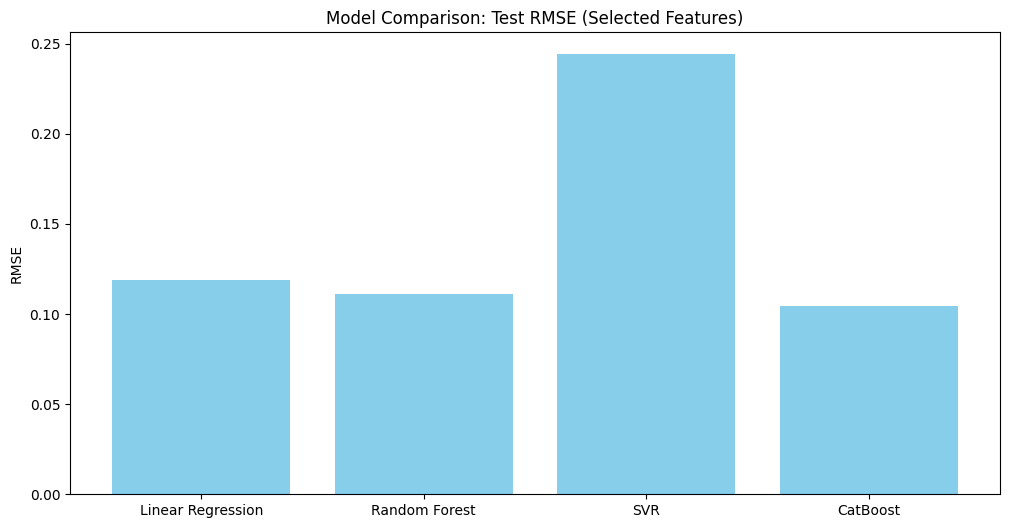

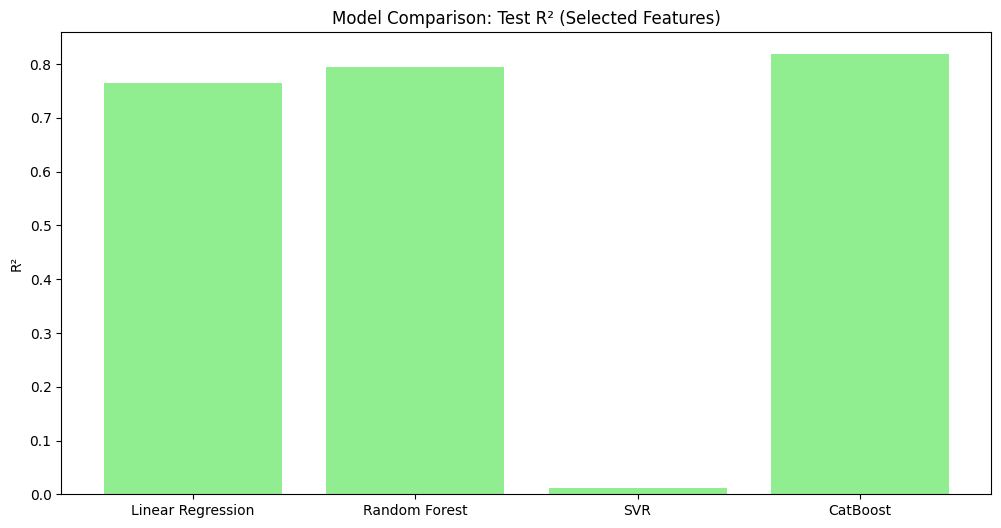

In [6]:
# Plot the baseline results
model_names = list(baseline_results.keys())
rmse_values = [baseline_results[name]['RMSE Test'] for name in model_names]
r2_values = [baseline_results[name]['R² Test'] for name in model_names]

# RMSE
plt.figure(figsize=(12, 6))
plt.bar(model_names, rmse_values, color='skyblue')
plt.title("Model Comparison: Test RMSE (Selected Features)")
plt.ylabel("RMSE")
plt.show()

# R²
plt.figure(figsize=(12, 6))
plt.bar(model_names, r2_values, color='lightgreen')
plt.title("Model Comparison: Test R² (Selected Features)")
plt.ylabel("R²")
plt.show()

In [7]:
# Re-train Models with Hyperparameter Tuning

# Define hyperparameter grids for tuning
param_grids = {
    "Linear Regression": {},
    "SVR": {"C": [0.1, 1, 10], "gamma": ["scale", "auto"]},
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [10, 20]},
    "CatBoost": {
        "iterations": [500, 1000],
        "learning_rate": [0.01, 0.05],
        "depth": [4, 6],
    },
}

tuned_results = {}
for name, model in models.items():
    print(f"Tuning hyperparameters for {name} with selected features...")
    grid_search = GridSearchCV(
        model, param_grids[name], scoring="neg_mean_squared_error", cv=3
    )
    grid_search.fit(X_train_final, y_train)
    best_model = grid_search.best_estimator_

    predictions = best_model.predict(X_test_final)
    predictions_train = best_model.predict(X_train_final)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    r2_train = r2_score(y_train, predictions_train)

    tuned_results[name] = {
        "Best Params": grid_search.best_params_,
        "RMSE Test": rmse,
        "R² Test": r2,
        "RMSE Train": rmse_train,
        "R² Train": r2_train,
    }

Tuning hyperparameters for Linear Regression with selected features...
Tuning hyperparameters for Random Forest with selected features...
Tuning hyperparameters for SVR with selected features...
Tuning hyperparameters for CatBoost with selected features...


In [8]:
# Step 5: Compare Models
print("\nComparison of Hyperparameter Tuning:")
for name in models.keys():
    baseline_rmse = baseline_results[name]["RMSE Test"]
    tuned_rmse = tuned_results[name]["RMSE Test"]
    baseline_r2 = baseline_results[name]["R² Test"]
    tuned_r2 = tuned_results[name]["R² Test"]
    baseline_rmse_train = baseline_results[name]["RMSE Train"]
    tuned_rmse_train = tuned_results[name]["RMSE Train"]
    baseline_r2_train = baseline_results[name]["R² Train"]
    tuned_r2_train = tuned_results[name]["R² Train"]

    print(
        f"{name}: Untuned RMSE Train = {baseline_rmse_train:.4f}, Tuned RMSE Train = {tuned_rmse_train:.4f}"
    )
    print(
        f"{name}: Untuned R² Train = {baseline_r2_train:.4f}, Tuned R² Train = {tuned_r2_train:.4f}"
    )
    print(
        f"{name}: Untuned RMSE Test = {baseline_rmse:.4f}, Tuned RMSE Test = {tuned_rmse:.4f}"
    )
    print(
        f"{name}: Untuned R² Test = {baseline_r2:.4f}, Tuned R² Test = {tuned_r2:.4f}\n"
    )


Comparison of Hyperparameter Tuning:
Linear Regression: Untuned RMSE Train = 0.1191, Tuned RMSE Train = 0.1191
Linear Regression: Untuned R² Train = 0.7736, Tuned R² Train = 0.7736
Linear Regression: Untuned RMSE Test = 0.1190, Tuned RMSE Test = 0.1190
Linear Regression: Untuned R² Test = 0.7651, Tuned R² Test = 0.7651

Random Forest: Untuned RMSE Train = 0.0668, Tuned RMSE Train = 0.0396
Random Forest: Untuned R² Train = 0.9287, Tuned R² Train = 0.9750
Random Forest: Untuned RMSE Test = 0.1113, Tuned RMSE Test = 0.1103
Random Forest: Untuned R² Test = 0.7945, Tuned R² Test = 0.7981

SVR: Untuned RMSE Train = 0.2488, Tuned RMSE Train = 0.0916
SVR: Untuned R² Train = 0.0122, Tuned R² Train = 0.8660
SVR: Untuned RMSE Test = 0.2441, Tuned RMSE Test = 0.1078
SVR: Untuned R² Test = 0.0124, Tuned R² Test = 0.8072

CatBoost: Untuned RMSE Train = 0.0866, Tuned RMSE Train = 0.0788
CatBoost: Untuned R² Train = 0.8803, Tuned R² Train = 0.9009
CatBoost: Untuned RMSE Test = 0.1047, Tuned RMSE Test

In [9]:
# Get the table of results
results_df = pd.DataFrame(tuned_results).T
results_df = results_df[
    ["RMSE Train", "R² Train", "RMSE Test", "R² Test", "Best Params"]
]
print(results_df)

                  RMSE Train  R² Train RMSE Test   R² Test  \
Linear Regression   0.119102  0.773595  0.119029   0.76513   
Random Forest       0.039555  0.975029  0.110347  0.798145   
SVR                  0.09162  0.866024  0.107833  0.807239   
CatBoost            0.078796  0.900904   0.10436  0.819455   

                                                         Best Params  
Linear Regression                                                 {}  
Random Forest                 {'max_depth': 20, 'n_estimators': 200}  
SVR                                        {'C': 1, 'gamma': 'auto'}  
CatBoost           {'depth': 4, 'iterations': 1000, 'learning_rat...  


In [10]:
# Save the results to a CSV file
results_df.to_csv("./data/model_comparison_results.csv")

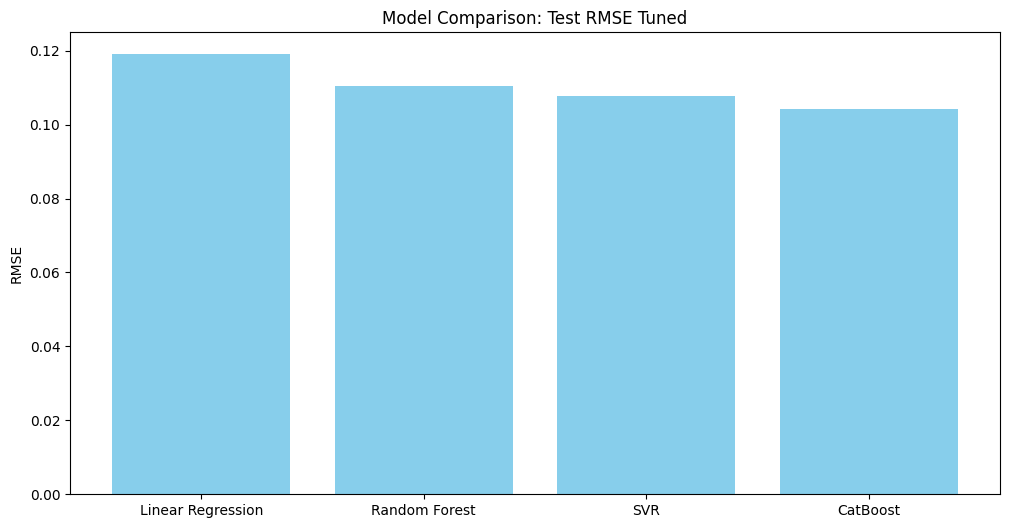

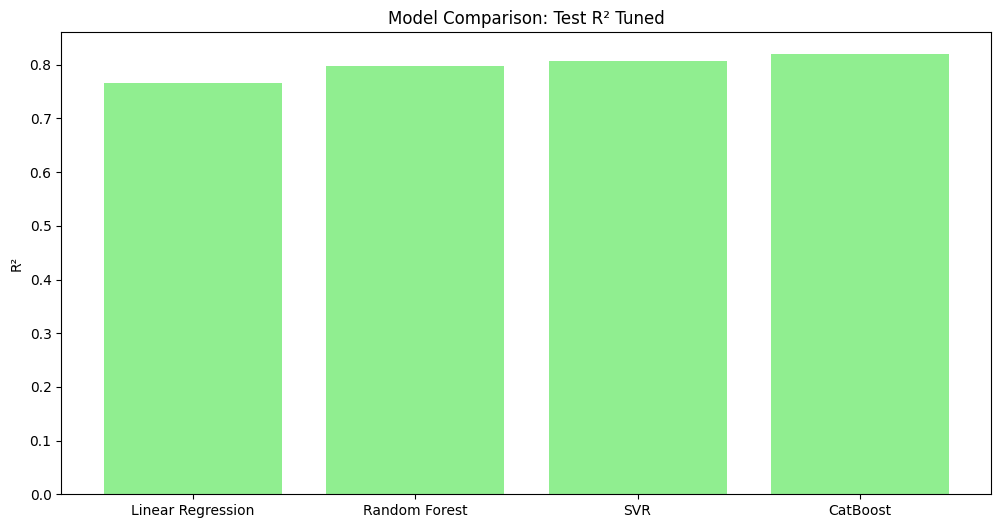

In [11]:
# RMSE
model_names = list(tuned_results.keys())
rmse_values = [tuned_results[name]["RMSE Test"] for name in model_names]
r2_values = [tuned_results[name]["R² Test"] for name in model_names]

plt.figure(figsize=(12, 6))
plt.bar(model_names, rmse_values, color="skyblue")
plt.title("Model Comparison: Test RMSE Tuned")
plt.ylabel("RMSE")
plt.show()

# R²
plt.figure(figsize=(12, 6))
plt.bar(model_names, r2_values, color="lightgreen")
plt.title("Model Comparison: Test R² Tuned")
plt.ylabel("R²")
plt.show()